# HW6
### Levi Neely
### u6019570
### 7/14/23
### CS 6017

In this homework we are going to work on classifying characters. We will start by uploading the data into a data frame and cleaning up the data to only be what we need to use.

In [6]:
import pandas as pd
import numpy as np
#Read in the .csv file
df = pd.read_csv("character+font+images/ARIAL.csv")
#Only keep the m_label and data columns
columns_to_keep = ['m_label'] + [f'r{row}c{col}' for row in range(20) for col in range(20)]
df = df[columns_to_keep]
#Filter out labels that occur 5 or fewer times
label_counts = df['m_label'].value_counts()
labels_to_filter = label_counts[label_counts <= 5].index.tolist()
df = df[~df['m_label'].isin(labels_to_filter)]
#Function to produce the numpy arrays and index/unicode dictionaries from the data
def array_from_dataframe(dataframe):
    #Get the number of samples and initialize everything
    num_samples = dataframe.shape[0]
    Xs = np.empty((num_samples, 20, 20))
    Ys = np.empty(num_samples)
    unicode_to_index = {}
    index_to_unicode = {}
    index = 0
    #Fill in the arrays and dictionaries
    for i, row in enumerate(dataframe.iterrows()):
        _, data = row
        label = data['m_label']
        array_data = data[1:].to_numpy().reshape(20, 20)
        array_data = array_data / 255.0
        Xs[i] = array_data
        #For every unique unicode value, shrink it down to smaller indeces
        if label not in unicode_to_index:
            unicode_to_index[label] = index
            index_to_unicode[index] = label
            index += 1
        Ys[i] = label
    return Xs, Ys, unicode_to_index, index_to_unicode
Xs, Ys, unicode_to_index, index_to_unicode = array_from_dataframe(df)
print(Xs.shape, Ys.shape)

(17824, 20, 20) (17824,)


Now we can just double check that our data is in a good spot and print out some of the values:

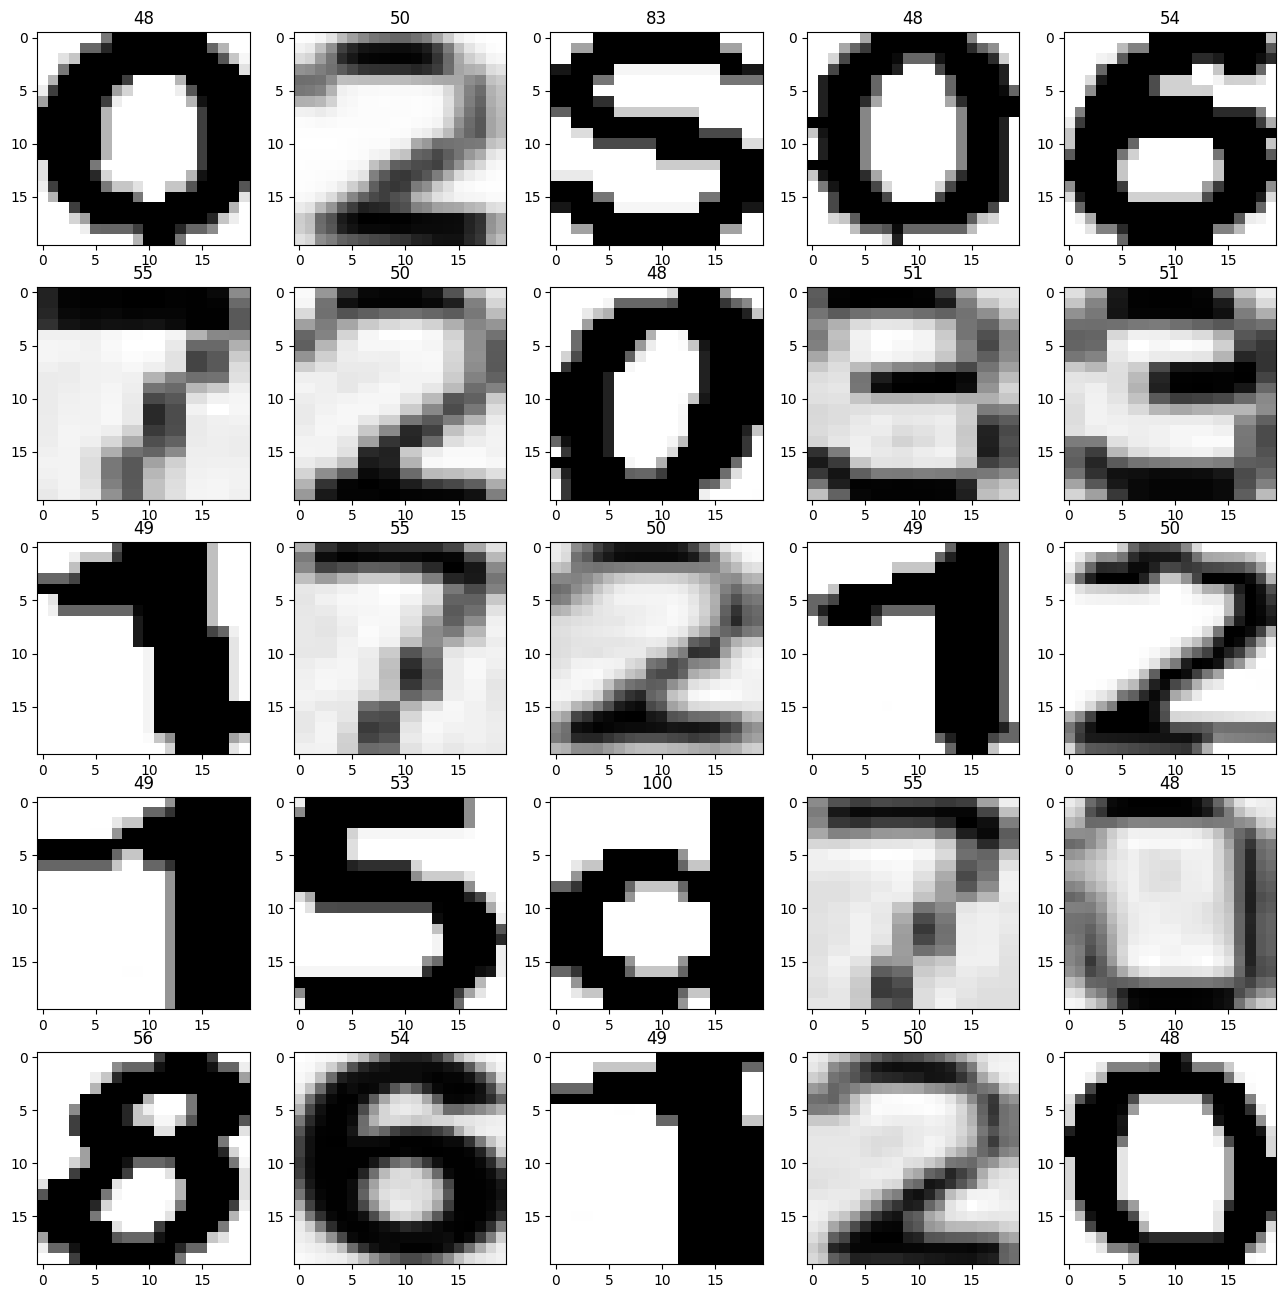

In [7]:
import matplotlib.pyplot as plt
# Plot the first few images in the dataset...
plt.figure( figsize= (16, 16) )

for ii in np.arange( 25 ):
    plt.subplot( 5, 5, ii+1 )
    plt.imshow( Xs[ii, :, :], cmap='Greys',interpolation='none' )
    plt.title( int(Ys[ii]) )

plt.show()

Now that we have our data formatted, we can go ahead and build, train, and compile our CNN model:

In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

unique_chars = len(unicode_to_index)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 6 #The number of images that the first convolution layer will output
        c2Out = 16 #Same as above, but for the second convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 3) #This is doing the convolution
        self.pool = nn.MaxPool2d(2, 2) #This is doing the pooling in between the convolution
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #Second convolution layer
        #Pooling happens again here
        self.pooledOutputSize = c2Out*3*3
        self.fc1 = nn.Linear(self.pooledOutputSize, 3500) #Dense layer 1
        self.fc2 = nn.Linear(3500, unique_chars) #Makes sure that there are the same number of outputs availabe as unique chars, final dense layer
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Apply convolution filter, relu activation, then pool
        x = self.pool(F.relu(self.conv2(x))) #Second round
        x = x.view(-1, self.num_flat_features(x)) #Flatten everything to a 1D array
        x = F.relu(self.fc1(x)) #Dense layer 1 w/ ReLU activation
        x = self.fc2(x) #Final dense layer
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

Now it is time to train the net:

In [9]:
#First, split the data into training and testing data
#Reshape the data to make it work correctly
Xs = np.reshape(Xs, (-1, 1, 20, 20))
#A class to make the data work with the DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_array, labels_array):
        self.data = data_array
        self.labels = labels_array

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_sample = self.data[idx]
        label = self.labels[idx]

        #Convert data and label to PyTorch tensors
        data_tensor = torch.tensor(data_sample, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return data_tensor, label_tensor
#Generate a random permutation of indices
permutation_indices = np.random.permutation(len(Xs))
#Use the permutation to shuffle both arrays
shuffled_Xs = Xs[permutation_indices]
shuffled_Ys = Ys[permutation_indices]
#Calculate the index to split the arrays in half
split_index = int(len(Xs) * 0.8)
#Split both arrays into two parts
Xs_train, Xs_test = shuffled_Xs[:split_index], shuffled_Xs[split_index:]
Ys_train, Ys_test = shuffled_Ys[:split_index], shuffled_Ys[split_index:]
#Make datasets
for i in range(len(Ys_train)):
    Ys_train[i] = unicode_to_index[Ys_train[i]]
for i in range(len(Ys_test)):
    Ys_test[i] = unicode_to_index[Ys_test[i]]
training_data = CustomDataset(Xs_train, Ys_train)
testing_data = CustomDataset(Xs_test, Ys_test)

def train(model, epochs):
    criterion = nn.CrossEntropyLoss()
    #Use ADAM optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    #Load the data and get it into the right format
    trainloader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True, num_workers=0)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            #Get the inputs and labels
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    print('Finished Training')

def evaluate(model):
    #Load the test data
    testloader = torch.utils.data.DataLoader(testing_data, batch_size=8, shuffle=True, num_workers=0)
    correct = 0
    total = 0
    mislabeled_images = []
    with torch.no_grad(): #Don't change the weights since we're not training
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #Keep track of mislabeled images
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    mislabeled_images.append((labels[i].item(), predicted[i].item(), images[i]))
    print('Accuracy of the network on test images: %d %%' % (100*correct/total))
    return mislabeled_images

In [10]:
print("Training...")
train(net, 20)
print("Evaluating...")
mislabeled_images = evaluate(net)
print(len(mislabeled_images))

Training...
Finished Training
Evaluating...
Accuracy of the network on test images: 83 %
597


From the cells above, we can see that this particular network's accuracy is 83%.

Now we are going to test a different network topology. This one is going to have more dense layers and a different number of convolution outputs.

In [11]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        c1Out = 4 #The number of images that the first convolution layer will output
        c2Out = 6 #Same as above, but for the second convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 3) #This is doing the convolution
        self.pool = nn.MaxPool2d(2, 2) #This is doing the pooling in between the convolution
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #Second convolution layer
        self.pooledOutputSize = c2Out*3*3 #Third pooling
        self.fc1 = nn.Linear(self.pooledOutputSize, 5000) #Dense layer 1
        self.fc2 = nn.Linear(5000, 4000)
        self.fc3 = nn.Linear(4000, unique_chars) #Makes sure that there are the same number of outputs availabe as unique chars, final dense layer
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #Apply convolution filter, relu activation, then pool
        x = self.pool(F.relu(self.conv2(x))) #Second round
        x = x.view(-1, self.num_flat_features(x)) #Flatten everything to a 1D array
        x = F.relu(self.fc1(x)) #Dense layer 1 w/ ReLU activation
        x = F.relu(self.fc2(x)) #Dense layer 2
        x = self.fc3(x) #Final dense layer
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net2 = Net2()

Now let's train and test this new network and see how it compares to the other one:

In [12]:
print("Training...")
train(net2, 2)
print("Evaluating...")
mislabeled_images = evaluate(net2)
print(len(mislabeled_images))

Training...
Finished Training
Evaluating...
Accuracy of the network on test images: 55 %
1571


Now that we know that the first network was more effective, we are going to test that one against a different set of characters to see how it performs.

In [13]:
#Read in the .csv file
df2 = pd.read_csv("character+font+images/TIMES.csv")
#Only keep the m_label and data columns
columns_to_keep = ['m_label'] + [f'r{row}c{col}' for row in range(20) for col in range(20)]
df2 = df2[columns_to_keep]
#Filter out labels that occur 5 or fewer times
label_counts = df2['m_label'].value_counts()
labels_to_filter = label_counts[label_counts <= 5].index.tolist()
df2 = df2[~df2['m_label'].isin(labels_to_filter)]
Xs, Ys, unicode_to_index, index_to_unicode = array_from_dataframe(df2)
#Reshape the data to make it work correctly
Xs = np.reshape(Xs, (-1, 1, 20, 20))
Xs_test = Xs
Ys_test = Ys
#Make datasets
for i in range(len(Ys_test)):
    Ys_test[i] = unicode_to_index[Ys_test[i]]
testing_data = CustomDataset(Xs_test, Ys_test)
#Evaluate
print("Evaluating...")
mislabeled_images = evaluate(net)
print(len(mislabeled_images))

Evaluating...
Accuracy of the network on test images: 8 %
1904


Now that we know that the accuracy of that network on a font it didn't train on was 8%, let's test it if we take that same network and train it with two fonts at once and then test it on a third font not trained previously:

In [14]:
#Combine the two datasets
combined_df = pd.concat([df, df2], ignore_index=True)
#Get the data into the format we need
Xs, Ys, unicode_to_index, index_to_unicode = array_from_dataframe(combined_df)
unique_chars = len(unicode_to_index)
#Reshape the data to make it work correctly
Xs = np.reshape(Xs, (-1, 1, 20, 20))
#Generate a random permutation of indices
permutation_indices = np.random.permutation(len(Xs))
#Use the permutation to shuffle both arrays
shuffled_Xs = Xs[permutation_indices]
shuffled_Ys = Ys[permutation_indices]
#Calculate the index to split the arrays in half
split_index = int(len(Xs) * 0.8)
#Split both arrays into two parts
Xs_train, Xs_test = shuffled_Xs[:split_index], shuffled_Xs[split_index:]
Ys_train, Ys_test = shuffled_Ys[:split_index], shuffled_Ys[split_index:]
#Make datasets
for i in range(len(Ys_train)):
    Ys_train[i] = unicode_to_index[Ys_train[i]]
for i in range(len(Ys_test)):
    Ys_test[i] = unicode_to_index[Ys_test[i]]
training_data = CustomDataset(Xs_train, Ys_train)
testing_data = CustomDataset(Xs_test, Ys_test)
#Create the new network
net3 = Net()

In [15]:
#Train the network on the two combined fonts
print("Training...")
train(net3, 20)
print("Evaluating...")
mislabeled_images = evaluate(net)
print(len(mislabeled_images))

Training...
Finished Training
Evaluating...
Accuracy of the network on test images: 86 %
519


In [16]:
#Test the network on a third font
#Read in the .csv file
new_font = pd.read_csv("character+font+images/CALIBRI.csv")
#Only keep the m_label and data columns
columns_to_keep = ['m_label'] + [f'r{row}c{col}' for row in range(20) for col in range(20)]
new_font = new_font[columns_to_keep]
#Filter out labels that occur 5 or fewer times
label_counts = new_font['m_label'].value_counts()
labels_to_filter = label_counts[label_counts <= 5].index.tolist()
new_font = new_font[~new_font['m_label'].isin(labels_to_filter)]
Xs, Ys, unicode_to_index, index_to_unicode = array_from_dataframe(new_font)
#Reshape the data to make it work correctly
Xs = np.reshape(Xs, (-1, 1, 20, 20))
Xs_test = Xs
Ys_test = Ys
#Make datasets
for i in range(len(Ys_test)):
    Ys_test[i] = unicode_to_index[Ys_test[i]]
testing_data = CustomDataset(Xs_test, Ys_test)
#Evaluate
print("Evaluating...")
mislabeled_images = evaluate(net3)
print(len(mislabeled_images))

Evaluating...
Accuracy of the network on test images: 0 %
19044


It looks as though my networks were not very adept at distinguishing between the different font, even when trained on the two fonts together. 

Let's take a look at the most frequently mislabeled images and see if we can find some common problems:

In [17]:
#Get the top five most common mislabeled images
from collections import Counter

def get_top_five_most_common(mislabeled_images):
    label_counter = Counter(item[0] for item in mislabeled_images)
    top_five_labels = label_counter.most_common(5)
    top_five_images_dict = {}
    for label, _ in top_five_labels:
        top_five_images_dict[label] = [(item[1], item[2]) for item in mislabeled_images if item[0] == label]
    return top_five_images_dict

error_images = get_top_five_most_common(mislabeled_images)

Network mistook 7586 for 43868 50.0 % of the time
[978, 3362, 5743, 8127, 10510] [14, 2398, 4779, 7163, 9546]


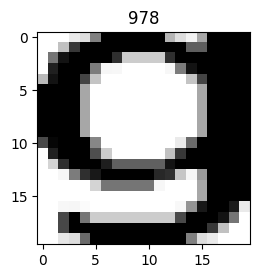

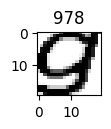

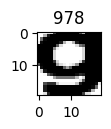

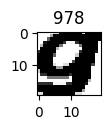

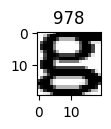

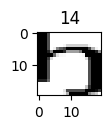

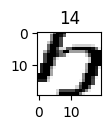

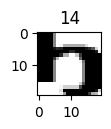

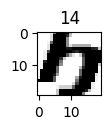

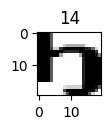

Network mistook 8071 for 8083 75.0 % of the time
[558, 2942, 5323, 7707, 10090] [546, 2930, 5311, 7695, 10078]


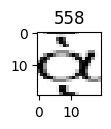

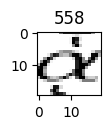

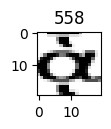

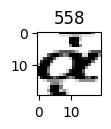

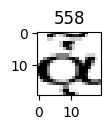

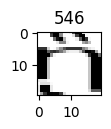

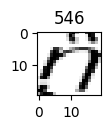

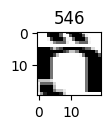

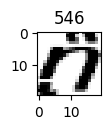

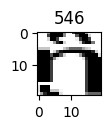

Network mistook 8150 for 8010 75.0 % of the time
[483, 2867, 5248, 7632, 10015] [611, 2995, 5376, 7760, 10143]


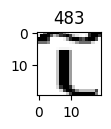

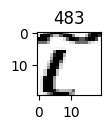

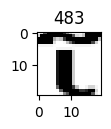

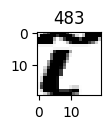

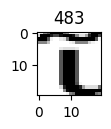

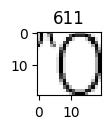

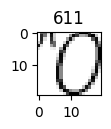

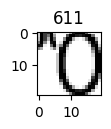

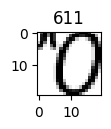

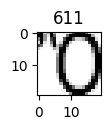

Network mistook 7809 for 8089 87.5 % of the time
[806, 3190, 5571, 7955, 10338] [540, 2924, 5305, 7689, 10072]


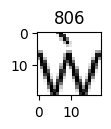

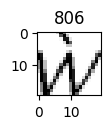

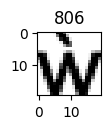

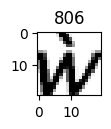

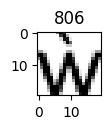

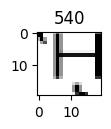

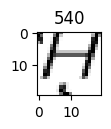

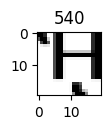

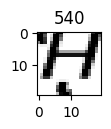

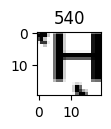

Network mistook 7692 for 42906 87.5 % of the time
[923, 3307, 5688, 8072, 10455] [89, 2473, 4854, 7238, 9621]


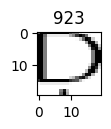

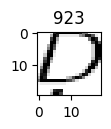

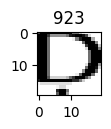

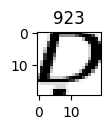

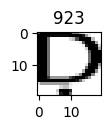

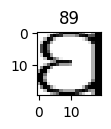

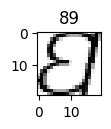

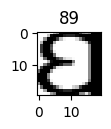

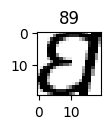

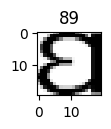

In [18]:
#Make the plot
plt.figure( figsize= (16, 16) )
#Get the most commonly mistaken value
for key in error_images.keys():
    correct_label = index_to_unicode[key]
    mis_labels = []
    for tuple in error_images[key]:
        if tuple[0] in index_to_unicode:
            value = index_to_unicode[tuple[0]]
            mis_labels.append(value)
    counter = Counter(mis_labels)
    mis_labels = counter.most_common(1)
    frequency = mis_labels[0][1] / len(error_images[key]) * 100
    print("Network mistook", correct_label, "for", mis_labels[0][0], frequency, "% of the time")
    index = []
    mis_index = []
    for i, x in enumerate(Ys):
        x = index_to_unicode[x]
        if x == correct_label:
            if len(index) == 5:
                break
            else:
                index.append(i)
    for i, x in enumerate(Ys):
        x = index_to_unicode[x]
        if x == mis_labels[0][0]:
            if len(mis_index) == 5:
                break
            else:
                mis_index.append(i)
    print(index, mis_index)
    plot_index = 1
    for i in index:
        plt.subplot( 5, 1, plot_index )
        reshaped = np.reshape(Xs[i, :, :], (20, 20))
        plt.imshow( reshaped, cmap='Greys',interpolation='none' )
        plt.title( int(Ys[i]) )
        plot_index += 1
        plt.show()
    plot_index = 1
    for i in mis_index:
        plt.subplot( 5, 1, plot_index )
        reshaped = np.reshape(Xs[i, :, :], (20, 20))
        plt.imshow( reshaped, cmap='Greys',interpolation='none' )
        plt.title( int(Ys[i]) )
        plot_index += 1
        plt.show()


Based off of this, it looks like my network had a harder time distinguishing curves. It did seem like this was due more to the fact that there were some foreign characters were too similar to other roman letters.